In this notebook, we will build a model that predicts the probability of a stock price falling into different ranges based on its price actions during last few days, weeks, months and the general market trend.
   

In [1]:
import yfinance as yf
import pandas as pd    
import numpy as np
import time
from datetime import datetime
from datetime import timedelta 
import matplotlib.pyplot as plt
import seaborn as sns
import pickle

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.utils import class_weight
from xgboost import XGBClassifier
from sklearn.metrics import log_loss

In [ ]:
start_date = datetime.fromisoformat("2017-01-01")  # last 4 years data is used (1st yr will be used for MA)
end_date = datetime.fromisoformat("2021-09-30")

tickers_sp500 = np.load('tickers_sp500.npy')
df = yf.download(list(tickers_sp500), start='2017-01-05', end='2017-01-06') 
tickers_sp500 = list(df['Close'].columns[~df.iloc[0].Close.isna()])        # filter out tickers that weren't public in 2017
tickers_sp500 = [tickers_sp500[10*x:10*(x+1)] for x in range(len(tickers_sp500)//10+1)]

volitility = pd.Series(dtype='float64')
for ticks in tickers_sp500:
    df = yf.download(ticks, period='1y', interval='1mo', progress=False)
    volitility = volitility.append(((df['High'] - df['Low'])/df['Open']).sum())    
ticker_list = list(volitility.nlargest(100).index)      # find 100 top volitile sp500 tickers

### Feature engineering

In [19]:
# usually fast movement in the treasury bill interest rates, usually resulting from fed's decisions, negatively affect the market specially tech stocks, so it's good to add 10yr rate as a feature
rate = yf.download('^tnx', start=start_date, end=end_date, progress=False)
rate['ty_change_5d'] = rate['Close']-rate['Close'].shift(periods=5)
rate.drop(columns=['Open', 'High', 'Low', 'Close', 'Volume'], inplace=True)
rate.rename(columns={"Adj Close": "ty"}, inplace=True)

# volitility index (vix) can be another useful feature
vix = yf.download('^vix', start=start_date, end=end_date, progress=False)

In [14]:
def price_change(df, period):
    df['change_'+str(period)+'d'] = (df['Close']-df['Close'].shift(periods=period))/df['Close'].shift(periods=period)   #StandardScaler().fit_transform(tmp.values.reshape(-1,1))
    df.drop('Close_y', axis=1, inplace=True)
    return df

# sp500, nasdaq composite and their changes can signal market general trend 
sp = yf.download('^gspc', start=start_date, end=end_date, progress=False)
sp = price_change(sp, 1)
sp = price_change(sp, 5)
sp.drop(columns=['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume'], inplace=True)
sp.rename(columns={'change_1d':'sp_change_1d', 'change_5d':'sp_change_5d'}, inplace=True)

nasd = yf.download('^ixic', start=start_date, end=end_date, progress=False)
nasd = price_change(nasd, 1)
nasd = price_change(nasd, 5)
nasd.drop(columns=['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume'], inplace=True)
nasd.rename(columns={'change_1d':'nas_change_1d', 'change_5d':'nas_change_5d'}, inplace=True)

In [35]:
def stock_data_prep(ticker):
    data = yf.download(ticker, start=start_date, end=end_date, progress=False)
    data['swing'] = (data['High']-data['Low'])/data['Close']
    data['vol'] = data['Volume']/data['Volume'].rolling(50).mean()
    data.drop(columns=['Open', 'High', 'Low', 'Adj Close', 'Volume'], inplace=True)
    
    data = pd.merge(data, vix['Close'].rename('vix'), on='Date')
    data = pd.merge(data, rate, on='Date')
    data = pd.merge(data, sp, on='Date')
    data = pd.merge(data, nasd, on='Date')
    
    data = price_change(data, 1)
    data = price_change(data, 2)
    data = price_change(data, 3)
    data = price_change(data, 4)
    data = price_change(data, 5)
    data = price_change(data, 10)
    data = price_change(data, 20)

    # obviously, moving averages cannot be ingored for any technical analysis, here we use 50d and 200d MA
    data['ma_50d'] = data['Close'].rolling(50).mean()
    data['ma_200d'] = data['Close'].rolling(200).mean()
    
    data.rename(columns={"Close": "close"}, inplace=True)
    data = data[(data.index >= start_date+timedelta(days=365)) & (data.index <= end_date)]   
    # these feature will be used to predict tomorrow's closing price
    data['target'] = data['close'].shift(periods=-1)
    data.dropna(inplace=True)   
    return data

# generate 4yr df for each ticker and stack them
data_targ = pd.DataFrame()
for tick in ticker_list:
    data_targ = pd.concat([data_targ, stock_data_prep(tick)])
pd.to_pickle(data_targ, 'data_sp100_4yr')

In [47]:
data_targ = pd.read_pickle('data_sp100_4yr')
data_targ.reset_index(drop=True, inplace=True)
data_targ['target'] = data_targ['target']/data_targ['close']    # normalizing other prices by closing price
data_targ['ma_50d'] = data_targ['ma_50d']/data_targ['close']
data_targ['ma_200d'] = data_targ['ma_200d']/data_targ['close']
data_targ.drop(columns=['close'], inplace=True)
data_targ.head()

,swing,vol,vix,ty,ty_change_5d,sp_change_1d,sp_change_5d,nas_change_1d,nas_change_5d,change_1d,change_2d,change_3d,change_4d,change_5d,change_10d,change_20d,ma_50d,ma_200d,target
0,0.034884,0.418895,9.15,2.447,-0.020,0.006399,0.012147,0.008367,0.018638,-0.007692,0.070539,0.036145,0.053061,0.066116,0.007812,-0.026415,0.897364,0.533876,0.968992
1,0.076000,0.525261,9.22,2.453,0.039,0.004029,0.015421,0.001752,0.019969,-0.031008,-0.038462,0.037344,0.004016,0.020408,0.012146,-0.094203,0.935520,0.553460,0.988000
2,0.044534,0.492679,9.22,2.476,0.044,0.007034,0.020692,0.008286,0.026820,-0.012000,-0.042636,-0.050000,0.024896,-0.008032,-0.019841,-0.085185,0.956113,0.562672,0.975709
3,0.062241,0.905482,9.52,2.480,0.075,0.001662,0.027715,0.002919,0.036794,-0.024291,-0.036000,-0.065891,-0.073077,0.000000,-0.054902,-0.139286,0.989378,0.579108,0.987552
4,0.042017,0.886745,10.08,2.546,0.081,0.001303,0.020580,0.000865,0.022361,-0.012448,-0.036437,-0.048000,-0.077519,-0.084615,-0.059288,-0.140794,1.010756,0.588802,0.949580


In [48]:
print(f"shape info of data_stock: {data_targ.shape}")

shape info of data_stock: (93904, 19)


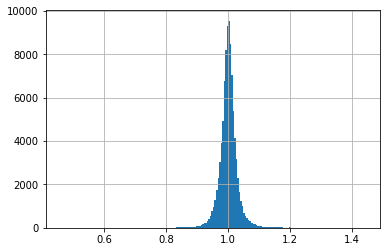

In [49]:
data_targ['target'].hist(bins=200)
data_targ = data_targ.query('.5 <= target <= 1.5')

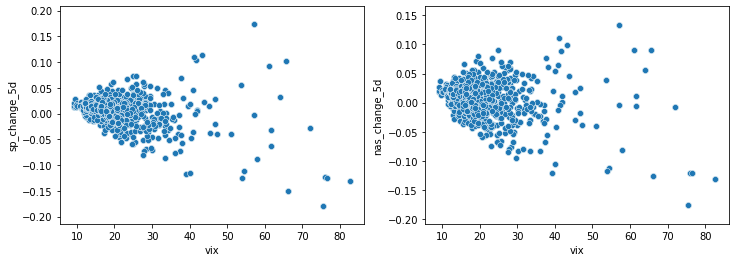

In [8]:
fig, axes = plt.subplots(1, 2, figsize=(12,4))
sns.scatterplot(x='vix', y='sp_change_5d', data=data_targ, ax=axes[0])
sns.scatterplot(x='vix', y='nas_change_5d', data=data_targ, ax=axes[1]);

Obviously, when vix increases both s&p and nasdaq show larger fluctuations.

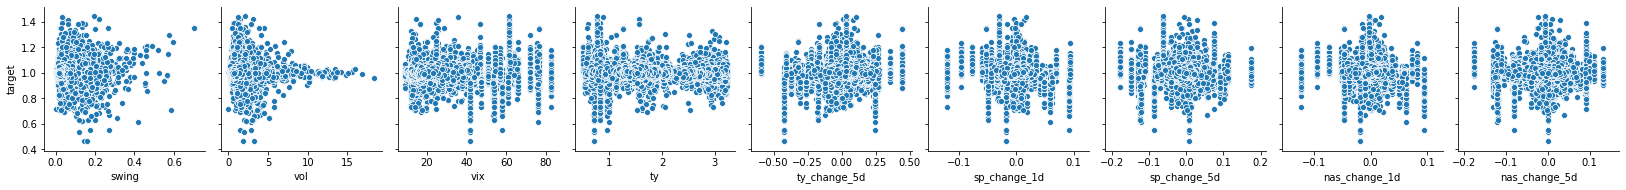

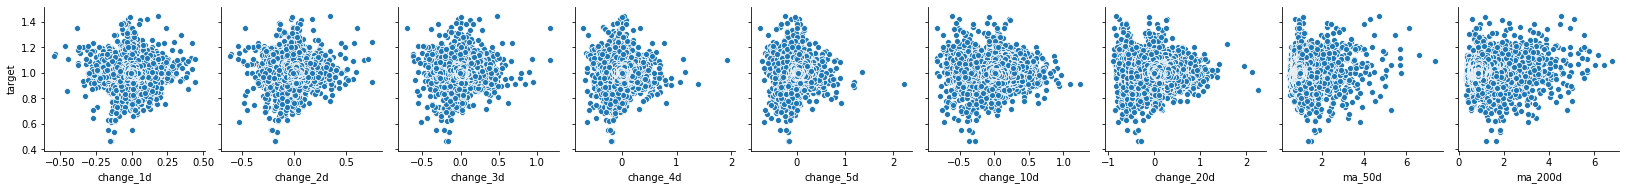

In [250]:
sns.pairplot(data=data_targ, y_vars=['target'], x_vars=data_targ.columns[0:9])
sns.pairplot(data=data_targ, y_vars=['target'], x_vars=data_targ.columns[9:18]);

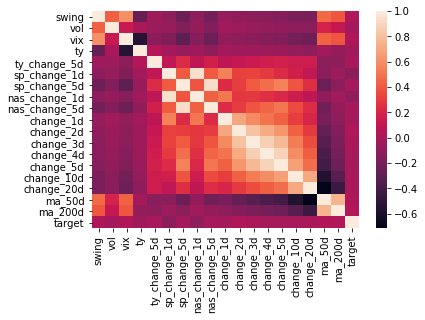

In [247]:
sns.heatmap(data_targ.corr());

### Model training/testing

Becuase of the limited sample size, we cannot predict tomorrow's price with a great accuracy. Instead, probability of price falling into different ranges will be predicted:

In [50]:
# digitize the ouput range
target_bins =  [0.5, .85, .9, .95, 1.05, 1.1, 1.15, 1.5]
class_no = len(target_bins)-1
X = data_targ.drop(columns='target')
y = np.digitize(data_targ['target'], target_bins)-1
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

(array([  222.,   384.,  2806., 86686.,  3044.,   497.,   263.]),
 array([0.5 , 0.85, 0.9 , 0.95, 1.05, 1.1 , 1.15, 1.5 ]),
 <a list of 7 Patch objects>)

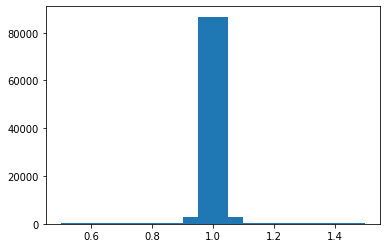

In [45]:
plt.hist(data_targ['target'], bins=target_bins)

In [99]:
# we want to predict the probability of each class so Brier scored is used for evaluation metric
def brier_score_xgb(y_prob, dtrain):
    y_true = np.int32(dtrain.get_label())
    brier_score = 0
    counter = 0
    for i, lable in enumerate(y_true):
        if lable!=class_no//2:        # because of class imbalance, the middle class which has the lowest importance for our strategy is neglected in early stopping
            brier_score +=  (1 - np.exp(y_prob[i, lable])/np.exp(y_prob[i,:]).sum())**2
            counter += 1
    return 'brier_loss', brier_score/counter
def brier_score(y_prob, y_true):
    brier_score = 0
    counter = 0
    for i, lable in enumerate(y_true):
        if lable!=class_no//2:
            brier_score +=  (1 - y_prob[i, lable])**2
            counter += 1
    return 'brier_loss', brier_score/counter

# because of class imbalance, each class is normalized by its weight
sample_weights = class_weight.compute_sample_weight(class_weight='balanced', y=y_train)

model = XGBClassifier(max_depth=4, learning_rate=.4,  n_estimators=1000)
model.fit(X_train, y_train,  verbose=50,  eval_set=[(X_train, y_train), (X_test, y_test)], eval_metric=brier_score_xgb, 
          early_stopping_rounds = 30, sample_weight=sample_weights)

[01:25:03] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[0]	validation_0-mlogloss:1.63618	validation_0-brier_loss:0.69143	validation_1-mlogloss:1.63788	validation_1-brier_loss:0.69531
[50]	validation_0-mlogloss:0.89842	validation_0-brier_loss:0.30378	validation_1-mlogloss:0.94074	validation_1-brier_loss:0.43647
[100]	validation_0-mlogloss:0.72121	validation_0-brier_loss:0.19242	validation_1-mlogloss:0.78843	validation_1-brier_loss:0.39460
[150]	validation_0-mlogloss:0.60490	validation_0-brier_loss:0.12794	validation_1-mlogloss:0.69421	validation_1-brier_loss:0.38268
[200]	validation_0-mlogloss:0.51145	validation_0-brier_loss:0.08700	validation_1-mlogloss:0.62065	validation_1-brier_loss:0.38304
[203]	validation_0-mlogloss:0.50735	validation_0-brier_loss:0.08539	validation_1-mlogloss:0.61765	va

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
              gamma=0, gpu_id=-1, importance_type=None,
              interaction_constraints='', learning_rate=0.4, max_delta_step=0,
              max_depth=4, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=1000, n_jobs=8,
              num_parallel_tree=1, objective='multi:softprob', predictor='auto',
              random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=None,
              subsample=1, tree_method='exact', validate_parameters=1,
              verbosity=None)

In [87]:
# comparing model performance with performance purely based on historical distributions (independent of input features)
y_dist = np.unique(y, return_counts=True)[1]/len(y)

print(f'model Brier score: {brier_score(model.predict_proba(X_test), y_test)[1]}')     
print(f'historical dist. Brier score: {brier_score(np.tile(y_dist,(len(y_test), 1)), y_test)[1]}')

model Brier score: 0.3798076138944038
historical dist. Brier score: 0.9486625501215984


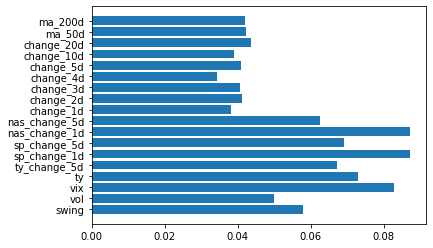

In [90]:
plt.barh(X.columns, model.feature_importances_);

It seems that general market trend is a good predictor for the future price action; however this partly can be due to the repetition of these features across samples.

now that we fine tuned our model, we run it on all of our data:

In [96]:
sample_weights = class_weight.compute_sample_weight(class_weight='balanced', y=y)
model = XGBClassifier(max_depth=4, learning_rate=.4,  n_estimators=173)
model.fit(X, y, sample_weight=sample_weights)

C:\ProgramData\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[23:54:45] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
              gamma=0, gpu_id=-1, importance_type=None,
              interaction_constraints='', learning_rate=0.4, max_delta_step=0,
              max_depth=4, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=173, n_jobs=8,
              num_parallel_tree=1, objective='multi:softprob', predictor='auto',
              random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=None,
              subsample=1, tree_method='exact', validate_parameters=1,
              verbosity=None)

In [97]:
model.save_model("model_xgboost_173estimators_depth4.json")